# Описание проекта
Пользователи размещают свои фотографии на хостинге и сопровождают их полным описанием: указывают место съёмок, модель камеры и т.д Пользователь сервиса вводит описание нужной сцены, а сервис выводит несколько фотографий с такой же или похожей сценой.

In [ ]:
from google.colab import files
from google.colab import drive
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
import nltk
import re
import os
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import transformers
from transformers import BertModel, BertTokenizerFast, BertConfig, AutoTokenizer
from tqdm import notebook
import torch
from nltk.corpus import stopwords
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import ResNet50
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
from sklearn.metrics import mean_absolute_error as MAE

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
RANDOM_STATE = 342
PATH = '/content/drive/MyDrive/to_upload'

# Загрузка данных

In [ ]:
test_images = pd.read_csv(PATH + '/test_images.csv', sep='|', index_col=0)
test_queries = pd.read_csv(PATH + '/test_queries.csv', on_bad_lines='skip',  sep='|')
train_df = pd.read_csv(PATH + '/train_dataset.csv', index_col=0)

crowd_annotations = pd.read_csv(PATH + '/CrowdAnnotations.tsv', sep='\t', header=None,
                                names=['image_name', 'describe_id', 'conf_perc', 'conf_count', 'not_conf_count'])

expert_annotations = pd.read_csv(PATH + '/ExpertAnnotations.tsv', sep='\t', header=None,
                                 names=['file_name', 'describe_id', 'expert_1', 'expert_2', 'expert_3'])

## Crowd annotation

In [ ]:
crowd_annotations.head()

image_name                  describe_id  conf_perc  \
0  1056338697_4f7d7ce270.jpg  1056338697_4f7d7ce270.jpg#2        1.0   
1  1056338697_4f7d7ce270.jpg   114051287_dd85625a04.jpg#2        0.0   
2  1056338697_4f7d7ce270.jpg  1427391496_ea512cbe7f.jpg#2        0.0   
3  1056338697_4f7d7ce270.jpg  2073964624_52da3a0fc4.jpg#2        0.0   
4  1056338697_4f7d7ce270.jpg  2083434441_a93bc6306b.jpg#2        0.0   

   conf_count  not_conf_count  
0           3               0  
1           0               3  
2           0               3  
3           0               3  
4           0               3

In [ ]:
crowd_annotations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47830 entries, 0 to 47829
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   image_name      47830 non-null  object 
 1   describe_id     47830 non-null  object 
 2   conf_perc       47830 non-null  float64
 3   conf_count      47830 non-null  int64  
 4   not_conf_count  47830 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 1.8+ MB


## Expert annotation

In [ ]:
expert_annotations.head()

file_name                  describe_id  expert_1  expert_2  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2         1         1   
1  1056338697_4f7d7ce270.jpg  2718495608_d8533e3ac5.jpg#2         1         1   
2  1056338697_4f7d7ce270.jpg  3181701312_70a379ab6e.jpg#2         1         1   
3  1056338697_4f7d7ce270.jpg  3207358897_bfa61fa3c6.jpg#2         1         2   
4  1056338697_4f7d7ce270.jpg  3286822339_5535af6b93.jpg#2         1         1   

   expert_3  
0         1  
1         2  
2         2  
3         2  
4         2

In [ ]:
expert_annotations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   file_name    5822 non-null   object
 1   describe_id  5822 non-null   object
 2   expert_1     5822 non-null   int64 
 3   expert_2     5822 non-null   int64 
 4   expert_3     5822 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 227.5+ KB


## Train data

In [ ]:
train_df = train_df.reset_index()

In [ ]:
train_df.head()

image                     query_id  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2   
1  1262583859_653f1469a9.jpg  2549968784_39bfbe44f9.jpg#2   
2  2447284966_d6bbdb4b6e.jpg  2549968784_39bfbe44f9.jpg#2   
3  2549968784_39bfbe44f9.jpg  2549968784_39bfbe44f9.jpg#2   
4  2621415349_ef1a7e73be.jpg  2549968784_39bfbe44f9.jpg#2   

                                          query_text  
0  A young child is wearing blue goggles and sitt...  
1  A young child is wearing blue goggles and sitt...  
2  A young child is wearing blue goggles and sitt...  
3  A young child is wearing blue goggles and sitt...  
4  A young child is wearing blue goggles and sitt...

In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image       5822 non-null   object
 1   query_id    5822 non-null   object
 2   query_text  5822 non-null   object
dtypes: object(3)
memory usage: 136.6+ KB


In [ ]:
test_queries = test_queries.drop('Unnamed: 0', axis=1)

In [ ]:
test_queries.head()

query_id  \
0  1177994172_10d143cb8d.jpg#0   
1  1177994172_10d143cb8d.jpg#1   
2  1177994172_10d143cb8d.jpg#2   
3  1177994172_10d143cb8d.jpg#3   
4  1177994172_10d143cb8d.jpg#4   

                                          query_text  \
0  Two blonde boys , one in a camouflage shirt an...   
1  Two boys are squirting water guns at each other .   
2            Two boys spraying each other with water   
3  Two children wearing jeans squirt water at eac...   
4  Two young boys are squirting water at each oth...   

                       image  
0  1177994172_10d143cb8d.jpg  
1  1177994172_10d143cb8d.jpg  
2  1177994172_10d143cb8d.jpg  
3  1177994172_10d143cb8d.jpg  
4  1177994172_10d143cb8d.jpg

In [ ]:
test_queries.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   query_id    500 non-null    object
 1   query_text  500 non-null    object
 2   image       500 non-null    object
dtypes: object(3)
memory usage: 11.8+ KB


## Test images

In [ ]:
test_images.head()

Empty DataFrame
Columns: []
Index: [3356748019_2251399314.jpg, 2887171449_f54a2b9f39.jpg, 3089107423_81a24eaf18.jpg, 1429546659_44cb09cbe2.jpg, 1177994172_10d143cb8d.jpg]

In [ ]:
test_images = test_images.reset_index()

# 1.Исследовательский анализ

In [ ]:
print('Количество уникальных изображений в обучающем множестве: ', train_df['image'].value_counts().shape[0])
print('Количество уникальных изображений в тестовом множестве: ', test_queries['image'].value_counts().shape[0])

Количество уникальных изображений в обучающем множестве:  1000
Количество уникальных изображений в тестовом множестве:  100


In [ ]:
print('Количество уникальных запросов в обучающем множестве: ', train_df['query_text'].value_counts().shape[0])
print('Количество уникальных запросов в тестовом множестве: ', test_queries['query_text'].value_counts().shape[0])

Количество уникальных запросов в обучающем множестве:  977
Количество уникальных запросов в тестовом множестве:  500


Количество уникальных запросов и фотографий в обучающем множестве разное 977 и 1000 соответсвенно, значит на один запрос может быть несколько фотографий. В тестовом множеестве количество уникальных запросов и фотографий тоже разное, 100 и 500 соответсвенно. Значит на одну фотографи может быть несколько запросов

In [ ]:
def load_images(path, dataframe, img_col_name):
  train_generator = ImageDataGenerator(rescale=1./255)

  return  train_generator.flow_from_dataframe(
    dataframe=dataframe,
    directory = path,
    x_col = img_col_name,
    target_size=(224, 224),
    class_mode = None,
    batch_size=32,
    shuffle=False,
  )

In [ ]:
def show_image(image):
    fig = plt.figure(figsize=(3,3))
    plt.imshow(image)
    plt.xticks([])
    plt.yticks([])
    plt.show()

In [ ]:
def show_image_and_query(image, text):
    print(text)
    show_image(image)

In [ ]:
flow_train_images = load_images(
    dataframe=train_df,
    path= PATH + '/train_images',
    img_col_name = 'image'
)
train_img = next(flow_train_images)

Found 5822 validated image filenames.


In [ ]:
flow_test_images = load_images(
    dataframe=test_queries,
    path= PATH + '/test_images',
    img_col_name = 'image'
)
test_img = next(flow_test_images)

Found 500 validated image filenames.


## 1.1 Show train images with query

A girl wearing a yellow shirt and sunglasses smiles .


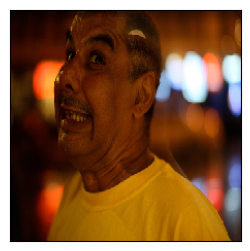

A young child is wearing blue goggles and sitting in a float in a pool .


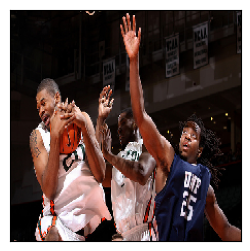

A young child is wearing blue goggles and sitting in a float in a pool .


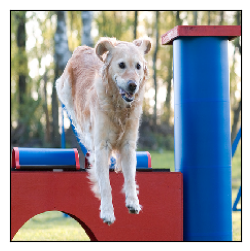

A young child is wearing blue goggles and sitting in a float in a pool .


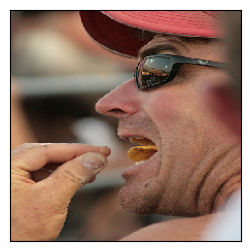

A girl wearing a yellow shirt and sunglasses smiles .


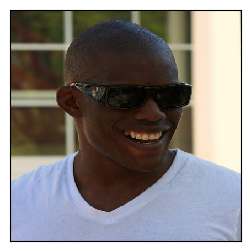

A girl wearing a yellow shirt and sunglasses smiles .


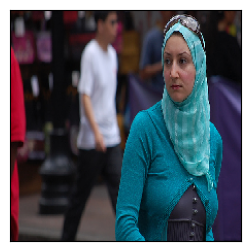

A young child is wearing blue goggles and sitting in a float in a pool .


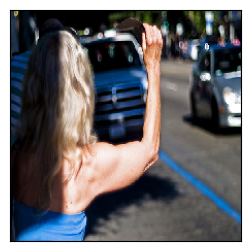

A girl wearing a yellow shirt and sunglasses smiles .


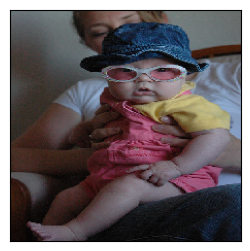

Chinese market street in the winter time .


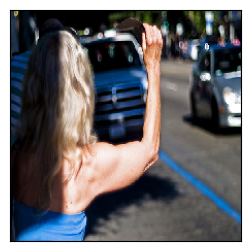

A young child is wearing blue goggles and sitting in a float in a pool .


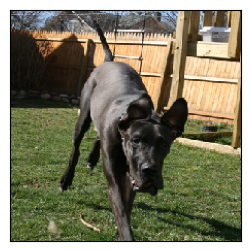

In [ ]:
random_idxs = np.random.choice(train_df.index[:32], size=10, replace=False)
for id in random_idxs:
  text = train_df['query_text'].iloc[id]
  img =train_img[id]
  show_image_and_query(img, text)

## 1.2 Show test images with query

A large tan dog sits on a grassy hill .


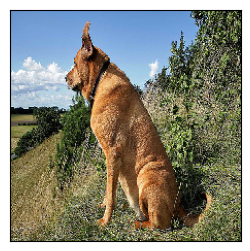

A closeup of a child on a playground with adult supervision .


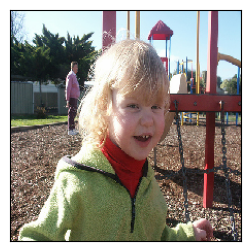

Two young boys are squirting water at each other .


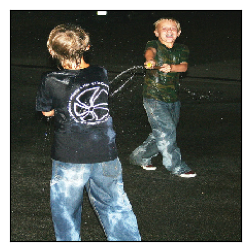

A brown dog sits still on a hillside .


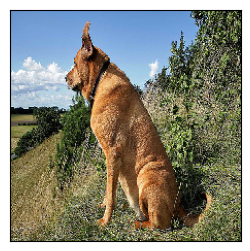

Girls wearing sports uniforms and eye protection .


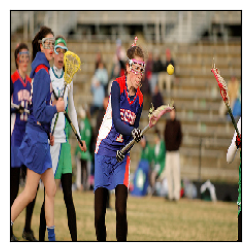

A large yellow dog is sitting on a hill .


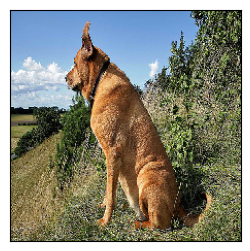

Two young girls on a playground .


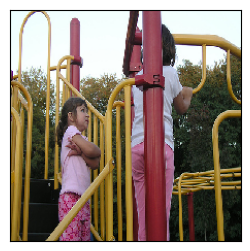

These girls are in uniforms and are playing field hockey .


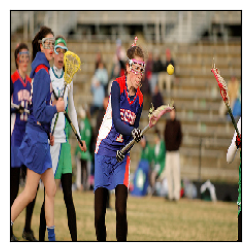

There is a little blond hair girl with a green sweatshirt and a red shirt playing on a playground .


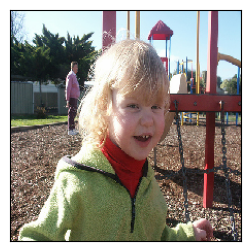

A man feeding a horse wearing a blue strapped blanket .


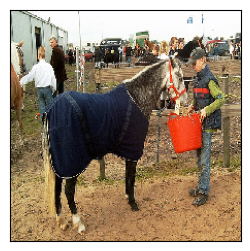

In [ ]:
random_idxs = np.random.choice(test_queries.index[:32], size=10, replace=False)
for id in random_idxs:
  text = test_queries['query_text'].iloc[id]
  img =test_img[id]
  show_image_and_query(img, text)

Сагрегирую оценки от краутсорсинга и экспертов следующим образом: оуенки экспертов переведу в диапозон от 0 до 1, далее сложу оценки с краутсорсинга с экспертными оценками с весам для каждого типа

In [ ]:
expert_annotations.head()

file_name                  describe_id  expert_1  expert_2  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2         1         1   
1  1056338697_4f7d7ce270.jpg  2718495608_d8533e3ac5.jpg#2         1         1   
2  1056338697_4f7d7ce270.jpg  3181701312_70a379ab6e.jpg#2         1         1   
3  1056338697_4f7d7ce270.jpg  3207358897_bfa61fa3c6.jpg#2         1         2   
4  1056338697_4f7d7ce270.jpg  3286822339_5535af6b93.jpg#2         1         1   

   expert_3  
0         1  
1         2  
2         2  
3         2  
4         2

In [ ]:
for i in range(1, 4):
    max_score = expert_annotations['expert_' + str(i)].max()
    print('max score of expert_' + str(i), ': ', max_score)

max score of expert_1 :  4
max score of expert_2 :  4
max score of expert_3 :  4


In [ ]:
for i in range(1, 4):
    max_score = expert_annotations['expert_' + str(i)].min()
    print('min score of expert_' + str(i), ': ', max_score)

min score of expert_1 :  1
min score of expert_2 :  1
min score of expert_3 :  1


## 1.3 Агригация оценок.

Для агрегации оценок приведу сумму оценок в диапозон от 0 до 1, по формуле x_new = (x - min) / (max - min), где min = 3, max = 12

In [ ]:
def agrigation(row):
    scores = []
    for i in range(1, 4):
        scores.append(row['expert_' + str(i)])

    sum_ = sum(scores)
    return  (sum_ - 3) / 9

In [ ]:
expert_annotations['agg_score'] = expert_annotations.apply(agrigation, axis=1)

In [ ]:
expert_annotations.head()

file_name                  describe_id  expert_1  expert_2  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2         1         1   
1  1056338697_4f7d7ce270.jpg  2718495608_d8533e3ac5.jpg#2         1         1   
2  1056338697_4f7d7ce270.jpg  3181701312_70a379ab6e.jpg#2         1         1   
3  1056338697_4f7d7ce270.jpg  3207358897_bfa61fa3c6.jpg#2         1         2   
4  1056338697_4f7d7ce270.jpg  3286822339_5535af6b93.jpg#2         1         1   

   expert_3  agg_score  
0         1   0.000000  
1         2   0.111111  
2         2   0.111111  
3         2   0.222222  
4         2   0.111111

In [ ]:
crowd_annotations.head()

image_name                  describe_id  conf_perc  \
0  1056338697_4f7d7ce270.jpg  1056338697_4f7d7ce270.jpg#2        1.0   
1  1056338697_4f7d7ce270.jpg   114051287_dd85625a04.jpg#2        0.0   
2  1056338697_4f7d7ce270.jpg  1427391496_ea512cbe7f.jpg#2        0.0   
3  1056338697_4f7d7ce270.jpg  2073964624_52da3a0fc4.jpg#2        0.0   
4  1056338697_4f7d7ce270.jpg  2083434441_a93bc6306b.jpg#2        0.0   

   conf_count  not_conf_count  
0           3               0  
1           0               3  
2           0               3  
3           0               3  
4           0               3

In [ ]:
crowd_annotations = crowd_annotations.rename(columns={'image_name':'file_name'})

Объеденю crowd_annotations и expert_annotation

In [ ]:
annotation = expert_annotations.merge(crowd_annotations, on=['describe_id', 'file_name'], how='left')

In [ ]:
annotation.head()

file_name                  describe_id  expert_1  expert_2  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2         1         1   
1  1056338697_4f7d7ce270.jpg  2718495608_d8533e3ac5.jpg#2         1         1   
2  1056338697_4f7d7ce270.jpg  3181701312_70a379ab6e.jpg#2         1         1   
3  1056338697_4f7d7ce270.jpg  3207358897_bfa61fa3c6.jpg#2         1         2   
4  1056338697_4f7d7ce270.jpg  3286822339_5535af6b93.jpg#2         1         1   

   expert_3  agg_score  conf_perc  conf_count  not_conf_count  
0         1   0.000000        0.0         0.0             3.0  
1         2   0.111111        0.0         0.0             3.0  
2         2   0.111111        NaN         NaN             NaN  
3         2   0.222222        NaN         NaN             NaN  
4         2   0.111111        NaN         NaN             NaN

In [ ]:
annotation = annotation.drop(['conf_count', 'not_conf_count'], axis=1)

In [ ]:
annotation.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5822 entries, 0 to 5821
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   file_name    5822 non-null   object 
 1   describe_id  5822 non-null   object 
 2   expert_1     5822 non-null   int64  
 3   expert_2     5822 non-null   int64  
 4   expert_3     5822 non-null   int64  
 5   agg_score    5822 non-null   float64
 6   conf_perc    2329 non-null   float64
dtypes: float64(2), int64(3), object(2)
memory usage: 363.9+ KB


In [ ]:
mean_conf_perc = annotation['conf_perc'].mean()
mean_agg_score = annotation['agg_score'].mean()

In [ ]:
#annotation['conf_perc'] = annotation.apply(fill_conf_perc, axis=1)
#annotation['agg_score'] = annotation.apply(fill_agg_score, axis=1)

In [ ]:
annotation

file_name                  describe_id  expert_1  \
0     1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2         1   
1     1056338697_4f7d7ce270.jpg  2718495608_d8533e3ac5.jpg#2         1   
2     1056338697_4f7d7ce270.jpg  3181701312_70a379ab6e.jpg#2         1   
3     1056338697_4f7d7ce270.jpg  3207358897_bfa61fa3c6.jpg#2         1   
4     1056338697_4f7d7ce270.jpg  3286822339_5535af6b93.jpg#2         1   
...                         ...                          ...       ...   
5817   997722733_0cb5439472.jpg  2981702521_2459f2c1c4.jpg#2         1   
5818   997722733_0cb5439472.jpg  2985679744_75a7102aab.jpg#2         1   
5819   997722733_0cb5439472.jpg  3150742439_b8a352e1e0.jpg#2         1   
5820   997722733_0cb5439472.jpg  3375070563_3c290a7991.jpg#2         1   
5821   997722733_0cb5439472.jpg   486917990_72bd4069af.jpg#2         3   

      expert_2  expert_3  agg_score  conf_perc  
0            1         1   0.000000   0.000000  
1            1         2   0.111111   0.000000  
2            1         2   0.111111        NaN  
3            2         2   0.222222        NaN  
4            1         2   0.111111        NaN  
...        ...       ...        ...        ...  
5817         1         1   0.000000        NaN  
5818         1         1   0.000000   0.000000  
5819         1         2   0.111111   0.000000  
5820         1         1   0.000000        NaN  
5821         3         3   0.666667   0.333333  

[5822 rows x 7 columns]

Проведу агригацию оценок от краутсосинга и экспертов. Дам каждому источнику оценки по весу. получится следующая формула final_score = crowd_score*0.4 + experts_scores*0.6

In [ ]:
def final_score(row):
    if not(pd.isna(row['conf_perc'])) and not(pd.isna(row['agg_score'])):
        return row['conf_perc']*0.4 + row['agg_score']*0.6

    elif pd.isna(row['conf_perc']) and not(pd.isna(row['agg_score'])):
        return row['agg_score']

    elif not(pd.isna(row['conf_perc'])) and (pd.isna(row['agg_score'])):
        return row['conf_perc']

In [ ]:
annotation['score'] = annotation.apply(final_score, axis=1)

оставлю в таблице annotation только 'describe_id', 'image_name', 'file_name', 'score'

In [ ]:
annotation = annotation[['describe_id', 'file_name', 'score']]

In [ ]:
annotation.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5822 entries, 0 to 5821
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   describe_id  5822 non-null   object 
 1   file_name    5822 non-null   object 
 2   score        5822 non-null   float64
dtypes: float64(1), object(2)
memory usage: 181.9+ KB


In [ ]:
annotation.head()

describe_id                  file_name     score
0  2549968784_39bfbe44f9.jpg#2  1056338697_4f7d7ce270.jpg  0.000000
1  2718495608_d8533e3ac5.jpg#2  1056338697_4f7d7ce270.jpg  0.066667
2  3181701312_70a379ab6e.jpg#2  1056338697_4f7d7ce270.jpg  0.111111
3  3207358897_bfa61fa3c6.jpg#2  1056338697_4f7d7ce270.jpg  0.222222
4  3286822339_5535af6b93.jpg#2  1056338697_4f7d7ce270.jpg  0.111111

# 2.Проверка данных

In [ ]:
test_queries.head()

query_id  \
0  1177994172_10d143cb8d.jpg#0   
1  1177994172_10d143cb8d.jpg#1   
2  1177994172_10d143cb8d.jpg#2   
3  1177994172_10d143cb8d.jpg#3   
4  1177994172_10d143cb8d.jpg#4   

                                          query_text  \
0  Two blonde boys , one in a camouflage shirt an...   
1  Two boys are squirting water guns at each other .   
2            Two boys spraying each other with water   
3  Two children wearing jeans squirt water at eac...   
4  Two young boys are squirting water at each oth...   

                       image  
0  1177994172_10d143cb8d.jpg  
1  1177994172_10d143cb8d.jpg  
2  1177994172_10d143cb8d.jpg  
3  1177994172_10d143cb8d.jpg  
4  1177994172_10d143cb8d.jpg

Удалю все знаки припенания и приведу все к строчным буквам

In [ ]:
def preporation_sentence(sentence):
    sentence = " ".join([word.lower() for word in sentence.split()])
    regular_text =  re.sub(r'[^a-zA-Z]', ' ', sentence)
    return ' '.join(regular_text.split())

In [ ]:
test_queries['query_text'] = test_queries['query_text'].apply(preporation_sentence)
train_df['query_text'] = train_df['query_text'].apply(preporation_sentence)

Проведу провекру на запрещенные слова

In [ ]:
bad_words_list = ["violence", "terrorism", "extremism", "destruction", "liquidation", "destruction",
  "death", "murder", "cruelty", "separatism", "nationalism", "racism", "revolution", "coup", "Nazism",
  'niger', 'semitism', 'chock', 'hach', 'bomb', 'explosion', 'terrorist', 'sabotage', 'sabotage',
  'undermining', 'militants', 'terrorists', 'extremists', "offensive", "hostages", "hosting", "ransom",
  "self-detonation", "bomber", "jihad", "martyr", "radical", "radicalization", "drugs", "psychotropic", "drug",
  "cocaine", "heroin", "marijuana", "amphetamines", "ecstasy", "lysergic", "spices", "salts", "crystals",
  "drug dealers", "dealers", "suicide", 'death','kid', 'child' ,'boy', 'girl', 'blood', 'corpse']

In [ ]:
train_df

image                     query_id  \
0     1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2   
1     1262583859_653f1469a9.jpg  2549968784_39bfbe44f9.jpg#2   
2     2447284966_d6bbdb4b6e.jpg  2549968784_39bfbe44f9.jpg#2   
3     2549968784_39bfbe44f9.jpg  2549968784_39bfbe44f9.jpg#2   
4     2621415349_ef1a7e73be.jpg  2549968784_39bfbe44f9.jpg#2   
...                         ...                          ...   
5817   757046028_ff5999f91b.jpg  2061144717_5b3a1864f0.jpg#2   
5818   799486353_f665d7b0f0.jpg  2196107384_361d73a170.jpg#2   
5819   909808296_23c427022d.jpg  2112921744_92bf706805.jpg#2   
5820   929679367_ff8c7df2ee.jpg  3651971126_309e6a5e22.jpg#2   
5821   968081289_cdba83ce2e.jpg  2292406847_f366350600.jpg#2   

                                             query_text  
0     a young child is wearing blue goggles and sitt...  
1     a young child is wearing blue goggles and sitt...  
2     a young child is wearing blue goggles and sitt...  
3     a young child is wearing blue goggles and sitt...  
4     a young child is wearing blue goggles and sitt...  
...                                                 ...  
5817           a man in an ampitheater talking to a boy  
5818            a old man walks down the uncrowded road  
5819         a dog stands on the side of a grassy cliff  
5820                         a blurry photo of two dogs  
5821                          a man rows his boat below  

[5822 rows x 3 columns]

In [ ]:
def is_bad_words(row):
    count_bad_words = 0
    tokinazed_word = nltk.word_tokenize(row['query_text'])
    lemotized_word = [lemmatizer.lemmatize(word) for word in tokinazed_word]

    for bad_word in bad_words_list:
        if bad_word in lemotized_word:
            count_bad_words += 1

    if count_bad_words != 0 and row['score'] > 0:
        return True
    else:
        return False

In [ ]:
train_df = train_df.rename(columns={'query_id':'describe_id', 'image':'file_name'});

In [ ]:
train_df = train_df.merge(annotation, on=['file_name', 'describe_id'], how='inner')

In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5822 entries, 0 to 5821
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   file_name    5822 non-null   object 
 1   describe_id  5822 non-null   object 
 2   query_text   5822 non-null   object 
 3   score        5822 non-null   float64
dtypes: float64(1), object(3)
memory usage: 227.4+ KB


Заполню пропущенные значения в score 0, так как для данной пары описание - фотография оценки нету

In [ ]:
lemmatizer = WordNetLemmatizer()

In [ ]:
train_df['is_delete'] = train_df.apply(is_bad_words, axis=1)

In [ ]:
train_df.head()

file_name                  describe_id  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2   
1  1262583859_653f1469a9.jpg  2549968784_39bfbe44f9.jpg#2   
2  2447284966_d6bbdb4b6e.jpg  2549968784_39bfbe44f9.jpg#2   
3  2549968784_39bfbe44f9.jpg  2549968784_39bfbe44f9.jpg#2   
4  2621415349_ef1a7e73be.jpg  2549968784_39bfbe44f9.jpg#2   

                                          query_text     score  is_delete  
0  a young child is wearing blue goggles and sitt...  0.000000      False  
1  a young child is wearing blue goggles and sitt...  0.000000      False  
2  a young child is wearing blue goggles and sitt...  0.133333       True  
3  a young child is wearing blue goggles and sitt...  1.000000       True  
4  a young child is wearing blue goggles and sitt...  0.000000      False

Удалю данные, где имеются запрещенные слова

In [ ]:
train_df = train_df[train_df['is_delete'] == False]


In [ ]:
train_df = train_df.reset_index(drop=True)

In [ ]:
train_df = train_df.drop('is_delete', axis=1);

In [ ]:
train_df.head()

file_name                  describe_id  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2   
1  1262583859_653f1469a9.jpg  2549968784_39bfbe44f9.jpg#2   
2  2621415349_ef1a7e73be.jpg  2549968784_39bfbe44f9.jpg#2   
3  3155451946_c0862c70cb.jpg  2549968784_39bfbe44f9.jpg#2   
4  3222041930_f642f49d28.jpg  2549968784_39bfbe44f9.jpg#2   

                                          query_text  score  
0  a young child is wearing blue goggles and sitt...    0.0  
1  a young child is wearing blue goggles and sitt...    0.0  
2  a young child is wearing blue goggles and sitt...    0.0  
3  a young child is wearing blue goggles and sitt...    0.0  
4  a young child is wearing blue goggles and sitt...    0.0

In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4999 entries, 0 to 4998
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   file_name    4999 non-null   object 
 1   describe_id  4999 non-null   object 
 2   query_text   4999 non-null   object 
 3   score        4999 non-null   float64
dtypes: float64(1), object(3)
memory usage: 156.3+ KB


In [ ]:
train_df = train_df[['file_name', 'describe_id', 'query_text', 'score']]

# 3.Векторизация текста

Поскольку неизвестно насколько длинные описания смогут подаваться нашей модели на вход в будущем, то нужно установить фиксированую длину слова равную 64. Так же это нужно для модели

In [ ]:
MAX_WORD_LEN = 64

In [ ]:
config = BertConfig.from_pretrained('bert-base-uncased', output_hidden_states=True)
tokenizer = AutoTokenizer.from_pretrained('albert-base-v2')
BERT_model = BertModel.from_pretrained('bert-base-uncased', config=config)
bert_tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')

In [ ]:
def found_max_len(tokens):
  max_len = 0
  for token in tokens:
    if len(token) > max_len:
      max_len = len(token)

  return max_len

In [ ]:
def make_embedings(attention_mask, padded_vector, batch_size):
  embeddings = []
  for i in notebook.tqdm(range(padded_vector.shape[0] // batch_size)):
    batch_padded = torch.LongTensor(padded_vector[batch_size*i:batch_size*(i+1)])
    batch_attention_mask = torch.LongTensor(attention_mask[batch_size*i:batch_size*(i+1)])
    with torch.no_grad():
      batch_embeddings = BERT_model(batch_padded, attention_mask=batch_attention_mask)
    embeddings.append(batch_embeddings[0][:,0,:].numpy())
  return embeddings

In [ ]:
train_tokenized = train_df['query_text'].apply(lambda x: bert_tokenizer.encode(x, add_special_tokens=True))
test_tokenized = test_queries['query_text'].apply(lambda x: bert_tokenizer.encode(x, add_special_tokens=True))

In [ ]:
train_max_sent_len = found_max_len(train_tokenized)
test_max_sent_len = found_max_len(test_tokenized)

In [ ]:
train_padded_vector = np.array([i + [0]*(MAX_WORD_LEN - len(i)) for i in train_tokenized.values])

In [ ]:
train_attention_mask = np.where(train_padded_vector != 0, 1, 0)

In [ ]:
def add_embedings(train_attention_mask, train_padded_vector, train_df, path):
    train_embedings = make_embedings(train_attention_mask, train_padded_vector, 3)
    train_embedings = np.concatenate(train_embedings)
    train_embedings = pd.DataFrame(data=train_embedings)
    train_df = train_df.join(train_embedings, how='inner')
    train_df = train_df.drop('query_text', axis=1)
    train_df.to_csv(path + '/embeding_train_df.csv')

In [ ]:
add_embedings(train_attention_mask, train_padded_vector, train_df, PATH)

  0%|          | 0/1666 [00:00<?, ?it/s]

In [ ]:
train_df = pd.read_csv(PATH + '/embeding_train_df.csv', index_col=[0])

In [ ]:
train_df.head()

file_name                  describe_id  score         0  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2    0.0 -0.073042   
1  1262583859_653f1469a9.jpg  2549968784_39bfbe44f9.jpg#2    0.0 -0.073042   
2  2621415349_ef1a7e73be.jpg  2549968784_39bfbe44f9.jpg#2    0.0 -0.073042   
3  3155451946_c0862c70cb.jpg  2549968784_39bfbe44f9.jpg#2    0.0 -0.073042   
4  3222041930_f642f49d28.jpg  2549968784_39bfbe44f9.jpg#2    0.0 -0.073042   

          1         2         3         4        5         6  ...       758  \
0 -0.053438 -0.072035  0.171916  0.046027 -0.57184  0.150834  ... -0.251033   
1 -0.053438 -0.072035  0.171916  0.046027 -0.57184  0.150834  ... -0.251033   
2 -0.053438 -0.072035  0.171916  0.046027 -0.57184  0.150834  ... -0.251033   
3 -0.053438 -0.072035  0.171916  0.046027 -0.57184  0.150834  ... -0.251033   
4 -0.053438 -0.072035  0.171916  0.046027 -0.57184  0.150834  ... -0.251033   

       759       760       761       762       763       764       765  \
0 -0.35963 -0.252055  0.070873 -0.004924  0.713229  0.142376 -0.147511   
1 -0.35963 -0.252055  0.070873 -0.004924  0.713229  0.142376 -0.147511   
2 -0.35963 -0.252055  0.070873 -0.004924  0.713229  0.142376 -0.147511   
3 -0.35963 -0.252055  0.070873 -0.004924  0.713229  0.142376 -0.147511   
4 -0.35963 -0.252055  0.070873 -0.004924  0.713229  0.142376 -0.147511   

        766       767  
0  0.188481  0.557801  
1  0.188481  0.557801  
2  0.188481  0.557801  
3  0.188481  0.557801  
4  0.188481  0.557801  

[5 rows x 771 columns]

#4.Векторизация изображений

#4.1 Загрузка данных

In [ ]:
train_images = load_images(
    path = PATH + '/train_images',
    dataframe = train_df,
    img_col_name = 'file_name'
)
train_img = next(train_images)

Found 4998 validated image filenames.


In [ ]:
def show_images(images, count):
    fig = plt.figure(figsize=(10, 10))
    for i in range(count):
        fig.add_subplot(4, 4, i+1)
        plt.imshow(images[i])
        plt.xticks([])
        plt.yticks([])
        plt.tight_layout()

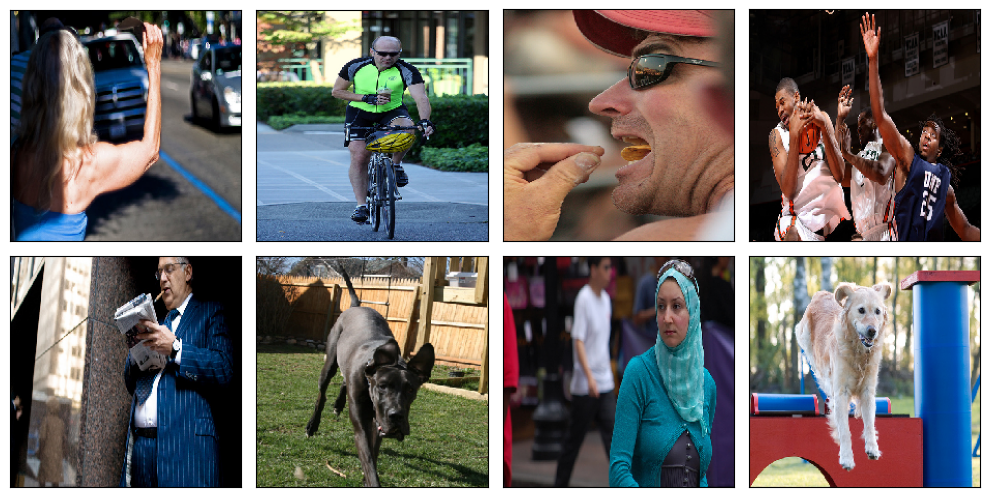

In [ ]:
show_images(train_img, 8)

Для векторизации текста и умееньшения размерности фотографии применю архитектуру Resnet50

In [ ]:
def vectorize_image(features):
  model = ResNet50(weights='imagenet',
                  input_shape=(224, 224, 3),
                  pooling='avg')
  return model.predict(features)

In [ ]:
def add_vectorize_images(train_images, train_df, path):
  vectorized_images = vectorize_image(train_images)
  vectorized_images = pd.DataFrame(vectorized_images)
  train_df = train_df.join(vectorized_images, rsuffix='_img')
  train_df.to_csv(path + '/final_train_df.csv')

In [ ]:
add_vectorize_images(train_images, train_df, PATH)

157/157 [==============================] - 1003s 6s/step


In [ ]:
train_df = pd.read_csv( PATH + '/final_train_df.csv',  index_col=[0]).drop(['file_name', 'describe_id'], axis=1)

In [ ]:
train_df.head()

score         0         1         2         3         4        5         6  \
0    0.0 -0.073042 -0.053438 -0.072035  0.171916  0.046027 -0.57184  0.150834   
1    0.0 -0.073042 -0.053438 -0.072035  0.171916  0.046027 -0.57184  0.150834   
2    0.0 -0.073042 -0.053438 -0.072035  0.171916  0.046027 -0.57184  0.150834   
3    0.0 -0.073042 -0.053438 -0.072035  0.171916  0.046027 -0.57184  0.150834   
4    0.0 -0.073042 -0.053438 -0.072035  0.171916  0.046027 -0.57184  0.150834   

          7         8  ...       990       991       992       993       994  \
0  0.892343 -0.454308  ...  0.000240  0.000024  0.000009  0.000075  0.000096   
1  0.892343 -0.454308  ...  0.000295  0.000025  0.000011  0.000059  0.000100   
2  0.892343 -0.454308  ...  0.000267  0.000032  0.000011  0.000080  0.000120   
3  0.892343 -0.454308  ...  0.000292  0.000021  0.000011  0.000056  0.000083   
4  0.892343 -0.454308  ...  0.000237  0.000022  0.000009  0.000069  0.000085   

        995       996       997       998       999  
0  0.000059  0.000113  0.000011  0.000105  0.000628  
1  0.000043  0.000064  0.000012  0.000117  0.000986  
2  0.000049  0.000095  0.000013  0.000136  0.000687  
3  0.000048  0.000076  0.000010  0.000116  0.001043  
4  0.000058  0.000103  0.000010  0.000110  0.000740  

[5 rows x 1769 columns]

In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4998 entries, 0 to 4997
Columns: 1769 entries, score to 999
dtypes: float64(1769)
memory usage: 67.5 MB


# 5.Обучение модели

В качестве метрики качества возьму MAPE

In [ ]:
tf.random.set_seed(RANDOM_STATE)

## 5.1 Разбиение данных

In [ ]:
X_train = train_df.drop('score', axis=1)
Y_train = train_df['score']

In [ ]:
X_train, X_valid, Y_train, Y_valid = train_test_split(X_train, Y_train, test_size=0.2)

Стандартизация данных

In [ ]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)

In [ ]:
Y_train = Y_train.values
Y_valid = Y_valid.values

In [ ]:
INPUT_SHAPE = (X_train.shape[1], )

## 5.2 Линейная регрессия

Так как задача регрессии, то в качастве функции потерь буду использовать MSE, в качестве метрики качества буду использовать MAE, так как она легко интерпритируема и устойчива к выбросам, а целевая переменная лежит в диапозоне от 0 до 1, из-за чего RMSE и MAPE не могут дать внятную интерпретируемость

In [ ]:
def create_lr_model(input_shape, regularizers, penalty):
  optimazer = keras.optimizers.Adam(learning_rate=0.001)

  model = keras.Sequential()
  model.add(keras.layers.Dense(1, input_shape = input_shape,
                               activation="linear",
                               kernel_regularizer=regularizers(penalty)))

  model.compile(optimizer=optimazer, loss='mean_squared_error', metrics=['mae'])
  model.build(input_shape = input_shape)
  return model

In [ ]:
def select_hyper_params(X_train, Y_train, X_valid, Y_valid, epochs, create_lr_model, lr_params):
  best_score = 100
  best_model = None
  best_regularizers = None
  best_penalty = 0
  best_lr = 0
  count = 0
  size = len(lr_params['regularizers']) * len( lr_params['penalty']) * len(lr_params['adam_lr'])

  for regularizers in lr_params['regularizers']:
    for penalty in lr_params['penalty']:
      for lr in lr_params['adam_lr']:
        lr_model = create_lr_model(input_shape=INPUT_SHAPE,
                                   regularizers = regularizers,
                                   penalty = penalty)

        lr_model.fit(X_train, Y_train, epochs=epochs, verbose=0)
        valid_predict = lr_model.predict(X_valid)
        valid_score = MAE(Y_valid, valid_predict)
        print('valid_score: ', valid_score)

        if valid_score < best_score:
          best_score = valid_score
          best_model = lr_model
          best_regularizers = regularizers
          best_penalty = penalty
          best_lr = lr

      if count % 10 == 0:
        print('==============', count/size, ' %=============')

      count +=1

  best_params = {
    'best_mae_score': best_score,
    'best_penalty':best_penalty,
    'best_lr': best_lr,
    'best_regularizers': best_regularizers
  }


  return best_model, best_params

In [ ]:
lr_params = {
    'regularizers': [keras.regularizers.l2, keras.regularizers.l1, keras.regularizers.l1_l2],
    'penalty': [0.1, 0.15, 0.2, 0.25, 0.3],
    'adam_lr':[0.00001, 0.0001]
}

In [ ]:
keras_lr_model, best_params = select_hyper_params(X_train = X_train,
                                            Y_train = Y_train,
                                            X_valid = X_valid,
                                            Y_valid = Y_valid,
                                            create_lr_model = create_lr_model,
                                            lr_params = lr_params,
                                            epochs = 50)

32/32 [==============================] - 0s 2ms/step
valid_score:  0.22565538313140474
32/32 [==============================] - 0s 2ms/step
valid_score:  0.22565165262569986
============== 0.0  %=============
32/32 [==============================] - 0s 2ms/step
valid_score:  0.22447302091767393
32/32 [==============================] - 0s 1ms/step
valid_score:  0.22447696778078877
32/32 [==============================] - 0s 3ms/step
valid_score:  0.2233671678112613
32/32 [==============================] - 0s 2ms/step
valid_score:  0.22336518632935157
32/32 [==============================] - 0s 2ms/step
valid_score:  0.22240528397444223
32/32 [==============================] - 0s 2ms/step
valid_score:  0.22241278013024066
32/32 [==============================] - 0s 2ms/step
valid_score:  0.22154142542464866
32/32 [==============================] - 0s 2ms/step
valid_score:  0.22154176267517936
32/32 [==============================] - 0s 7ms/step
valid_score:  0.17981654247144857
32/32 [==

In [ ]:
best_params

{'best_mae_score': 0.1732078764005833,
 'best_penalty': 0.15,
 'best_lr': 1e-05,
 'best_regularizers': keras.src.regularizers.L1}

In [ ]:
lr_model = LinearRegression().fit(X_train, Y_train)

In [ ]:
valid_predict = lr_model.predict(X_valid)
print('valid_MAE:', MAE(valid_predict, Y_valid))

valid_MAE: 4.644552205262294


<div class="alert" style="background-color:#ead7f7;color:#8737bf">
    <font size="3"><b>Комментария студента</b></font>
Если регрессию из sklearn использую, то получается какая-то аномальная ошибка

## 5.4 Полнсвязанная нейронная сеть

In [ ]:
def create_model(input_shape, count_layers):
  output = 128
  optimazer = keras.optimizers.Adam(learning_rate=0.00001)
  model = keras.Sequential()
  model.add(keras.layers.Dense(output, input_shape = input_shape, activation="relu"))

  for i in range(count_layers):
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Dense(output, activation='relu',
                                 kernel_regularizer=keras.regularizers.l1_l2(0.01)))

    model.add(keras.layers.Dropout(0.2))
    output = int(output / 2)

  model.add(keras.layers.Dense(1, activation='linear'))
  model.compile(optimizer=optimazer, loss='mean_squared_error', metrics=['mae'])

  model.build(input_shape=input_shape)
  return model

In [ ]:
NN_model = create_model(count_layers = 3, input_shape = INPUT_SHAPE)

In [ ]:
NN_model.summary()

Model: "sequential_93"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_102 (Dense)           (None, 128)               226432    
                                                                 
 batch_normalization_7 (Bat  (None, 128)               512       
 chNormalization)                                                
                                                                 
 dense_103 (Dense)           (None, 128)               16512     
                                                                 
 dropout_7 (Dropout)         (None, 128)               0         
                                                                 
 batch_normalization_8 (Bat  (None, 128)               512       
 chNormalization)                                                
                                                                 
 dense_104 (Dense)           (None, 64)              

In [ ]:
NN_model.fit(x = X_train,
             y = Y_train,
             validation_data = (X_valid, Y_valid),
             epochs = 100,
             verbose=1)

Epoch 1/100
125/125 [==============================] - 5s 17ms/step - loss: 25.9958 - mae: 0.8567 - val_loss: 25.0714 - val_mae: 0.4101
Epoch 2/100
125/125 [==============================] - 2s 13ms/step - loss: 25.8367 - mae: 0.8274 - val_loss: 25.1100 - val_mae: 0.4997
Epoch 3/100
125/125 [==============================] - 2s 12ms/step - loss: 25.6586 - mae: 0.7902 - val_loss: 25.0424 - val_mae: 0.5108
Epoch 4/100
125/125 [==============================] - 1s 11ms/step - loss: 25.5198 - mae: 0.7667 - val_loss: 24.9393 - val_mae: 0.5022
Epoch 5/100
125/125 [==============================] - 1s 11ms/step - loss: 25.4134 - mae: 0.7638 - val_loss: 24.8212 - val_mae: 0.4825
Epoch 6/100
125/125 [==============================] - 1s 9ms/step - loss: 25.2633 - mae: 0.7323 - val_loss: 24.7046 - val_mae: 0.4676
Epoch 7/100
125/125 [==============================] - 1s 8ms/step - loss: 25.1550 - mae: 0.7264 - val_loss: 24.5895 - val_mae: 0.4513
Epoch 8/100
125/125 [=============================

In [ ]:
valid_predict = NN_model.predict(X_valid)
valid_score = MAE(Y_valid, valid_predict)
print('valid_MAE: ', valid_score)

32/32 [==============================] - 0s 4ms/step
valid_MAE:  0.18025942878811724


По итогам обучения модели, линейная регрессия имеет меньше значение MAE на валидационной выборке, чем нейронная сеть, поэтому будет выбрана модель линейной регрессии

# 6.Тестирование модели

In [ ]:
test_datagen = ImageDataGenerator(rescale = 1/255)
test_flow = test_datagen.flow_from_dataframe(
    dataframe = test_images,
    directory = PATH + '/test_images',
    x_col = 'image',
    batch_size = 100,
    target_size=(224, 224),
    class_mode = None,
    shuffle=False,
    seed = RANDOM_STATE
)

Found 100 validated image filenames.


In [ ]:
def check_bad_words(text):
    count_bad_words = 0
    tokinazed_word = nltk.word_tokenize(text)
    lemotized_word = [lemmatizer.lemmatize(word) for word in tokinazed_word]

    for bad_word in bad_words_list:
        if bad_word in lemotized_word:
            count_bad_words += 1

    if count_bad_words != 0:
        return True
    else:
        return False

In [ ]:
def text_to_embeding(text):
    tok_text = bert_tokenizer.encode(text, add_special_tokens=True)
    padded_text = np.array([tok_text + [0]*(MAX_WORD_LEN - len(tok_text))])
    word_mask = np.where(padded_text != 0, 1, 0)
    padded_text = torch.LongTensor(padded_text)
    word_mask = torch.LongTensor(word_mask)
    with torch.no_grad():
        embeding = BERT_model(padded_text, attention_mask = word_mask).last_hidden_state[0][0].numpy()

    return embeding

In [ ]:
def found_best_index(text, vect_images, model):
    best_score = 0
    best_imgs_index = None
    emb_text = text_to_embeding(text)

    for i in range(len(vect_images)):
        vect_img = vect_images.iloc[i]
        input = np.concatenate((emb_text, vect_img)).reshape(1, 1768)
        score = model.predict(input, verbose=0)[0][0]

        if score > best_score:
            #print('score: ', score, 'index: ', i)
            best_imgs_index = i
            best_score = score

    return best_imgs_index, best_score

In [ ]:
def found_photo(text, vect_images, model):
    print(text)
    if check_bad_words(text):
        print('We can not show this image, becouse there ara any forbidden words in your request')
        print('===========================================================')
        return False

    best_idx, best_score = found_best_index(text, vect_images, model)
    print('accordance_score: ', best_score)
    fig = plt.figure(figsize=(3,3))
    plt.imshow(test_img[best_idx])
    plt.xticks([])
    plt.yticks([])
    plt.show()
    print('===========================================================')

In [ ]:
vect_imgs = pd.DataFrame(vectorize_image(test_img))

1/1 [==============================] - 13s 13s/step


## 6.1 Подбор фотографий

a biker is racing to keep up with the runners
accordance_score:  0.1761595


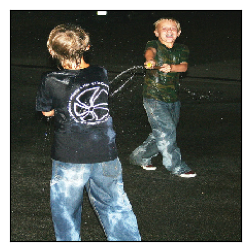

many people stand by watching a car smoke heavily
accordance_score:  0.17846666


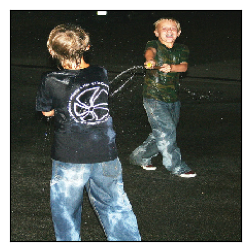

a person with blue hair a baseball cap and a hood on stands outdoors in a crowd
accordance_score:  0.1818925


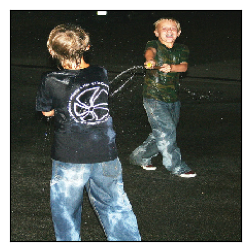

a boy flings sand at a girl
We can not show this image, becouse there ara any forbidden words in your request
a group of girls who are gothically dressed standing together
We can not show this image, becouse there ara any forbidden words in your request
a man in a black vest walks on a rail
accordance_score:  0.18588512


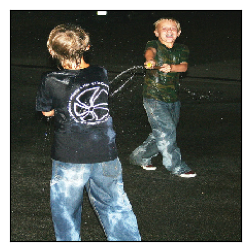

while holding tight to the ball the man in red socks is getting tackled
accordance_score:  0.17620774


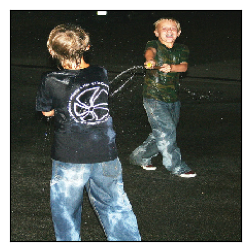

a snowboarder takes a ramp made of snow while others watch
accordance_score:  0.18175338


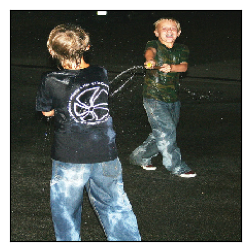

two women jump in the grass atop a mountain
accordance_score:  0.18498307


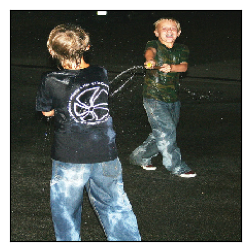

the man in the black shirt is pointing his camera at the arena
accordance_score:  0.17639041


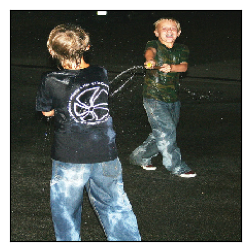

In [ ]:
random_idxs = np.random.choice(test_queries.index, size=10, replace=False)
for id in random_idxs:
  text = test_queries['query_text'].iloc[id]
  found_photo(text = text, vect_images = vect_imgs, model = keras_lr_model)

# 7 Вывод
Подход в объеденении векторов текста и векторов изображения в один не показал свою эффективность. При тестировании оценка всегда была равна ~ 0.18 и выводятся одни и теже фотографии, видимо модель запомнила одну "оптимальную" фотографию, при которой ошибка минимальна, и выдает ее. Возможно это связано со слишкой сложной структурой данных и недостатком их. Для решения проблемы можно попробывать другие архитектуры полносвязанных нейронных сетей